In [1]:
# metmast signals
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import inspect
import scipy as sp
import scipy.optimize as sciop

import total_var_functions as TV

%load_ext autoreload
%autoreload 2

In [2]:
#######################################
def total_variation(data,
                    blocksize=60,
                    detrend=None,
                    column=None,
                    window='slide',
                    fitcurve=None
                   ):
    '''
    Calculate the total variation of a dataset.
    Data is cut into blocks sequentially (window='block') or with a
    sliding window (window='slide'). 
    

    Parameters
    ----------
    data: df.DataFrame, np.ndarray
        input data of format (timeseries x datachannels)

    blocksize: int
        size of blocks for which to calculate total variation
        blocksize reflects the duration of each period in minutes

    detrend: None, list
        list of variables to detrend (linear)
        
    column: str
        name of column to detrend
    
    window: str
        'block' - sequential, non overlapping windows
        'slide' - overlapping windows of length 'blocksize' at each index

    fitcurve: str
        specify the fit function to use for detrending.
    
    Returns
    --------
    totalvar: df.Series
        Series of the total variation for each time period.
    '''

    if window == 'slide':
        timeind = data.index
    elif window == 'block':
        # make new time index (hourly)
        timeind = pd.date_range(start=data.index[0],
                                   freq='{}T'.format(blocksize),
                                   end=data.index[-1])

    nblocks = len(timeind) 

    # allocate space for totalvar
    totalvar = np.zeros(nblocks)

    # if detrending data, parse objective functino, and the number of required arguments
    if detrend is not None:
        fitfunc, param_names = TV.parse_fitfunc(detrend)
        param_names.append('residual')
        tmp = inspect.getfullargspec(fitfunc)
        nargs = len(tmp.args)
        fits = np.zeros((nblocks, nargs))  # slope, offset, residual
        x = np.arange(blocksize)

    nskip = 0
    timedelay = pd.Timedelta('{}m'.format(blocksize - 1))

    # loop over data blocks
    for ii in range(nblocks - 1):

        startind = timeind[ii]
        endind = startind + timedelay

        block = data[startind:endind].dropna(how='any').copy()

        if (len(block) < blocksize) | (any(block.std() == 0)):
            nskip += 1
            continue

        if detrend is not None:
            p0 = TV.parse_init_fitvals(detrend, block[column].values)

            try:
                fittest = sciop.curve_fit(fitfunc, x, block[column], p0)
                fitparams, _ = fittest
                fitcurve = fitfunc(x, *fitparams)
                residual = np.linalg.norm(block[column] -
                                          fitfunc(x, *fitparams))**2
            except:
                print('fit failed')
                fitparams = p0
                fitcurve = fitfunc(x, *fitparams)
                residual = np.nan

            block[column] -= (fitcurve + block[column].mean())
            fits[ii, :-1] = fitparams
            fits[ii, -1] = np.linalg.norm(residual)

        totalvar[ii] = TV.covdet(TV.standardize_data(block))

    # make dataframe for total variation
    totalvar = pd.DataFrame(data=totalvar, index=timeind, columns=['totalvar'])

    # if data has been detrended, add fit parameter columns to output dataframe
    if detrend is not None:

        fitcols = {'_'.join([column, x]): np.array([]) for x in param_names}
        fits = pd.DataFrame(index=totalvar.index, data=fits, columns=fitcols)
        totalvar = totalvar.join(fits)
    
    # replace 0.0 with np.nan
    totalvar.replace(0, np.nan, inplace=True)
    # Drop all nan values
    totalvar.dropna(inplace=True, how='all')


    return totalvar

## Load meteorological data

In [3]:
#### read pre-processed data.
metdf = pd.read_csv('metdata1T.csv')

# metdf = pd.read_csv('../../../data/metdata_2009.csv')
metdf.dropna(how='any', inplace=True)
metdf.index = pd.DatetimeIndex(metdf['Unnamed: 0'])
metdf.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
metdf.index.name = 'time'

In [4]:
tvar = total_variation(metdf, blocksize=60, window='block')

/usr/local/lib/python3.7/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [5]:
tvarLinear = total_variation(metdf, 
                       blocksize=60, 
                       window='block', 
                       detrend='linear', 
                       column='WS')

In [6]:
tvarWave = total_variation(metdf, 
                       blocksize=60, 
                       window='block', 
                       detrend='sine', 
                       column='WS')

fit failed


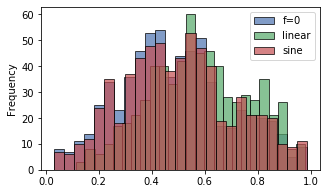

In [7]:
fig, ax = plt.subplots(figsize=(5,3))

tvar.plot.hist(bins=25, edgecolor='k', ax=ax, alpha=0.7)
tvarLinear['totalvar'].plot.hist(bins=25, edgecolor='k', ax=ax, alpha=0.7)
tvarWave['totalvar'].plot.hist(bins=25, edgecolor='k', ax=ax, alpha=0.7)
ax.legend(['f=0', 'linear', 'sine'])

fig.savefig('figs/tvar_detrend_distributions.pdf', bbox_inches='tight')

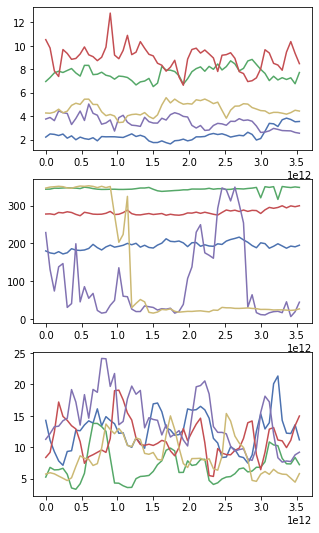

In [8]:
tvar_sort = tvar.sort_values('totalvar', ascending=False).copy()
starttimes = list(tvar_sort.index[0:5])

fig, ax = plt.subplots(3,1, figsize=(5,9))

blocksize = 60
dummyindex = pd.timedelta_range(start = 0, periods=blocksize, freq='1T')
for ii in starttimes:
    plotdat = metdf.loc[ii:ii+pd.Timedelta(blocksize-1, 'T')]
    plotdat.index = dummyindex
    
    ax[0].plot(plotdat.WS)
    ax[1].plot(plotdat.WD)
    ax[2].plot(plotdat.TI)
    

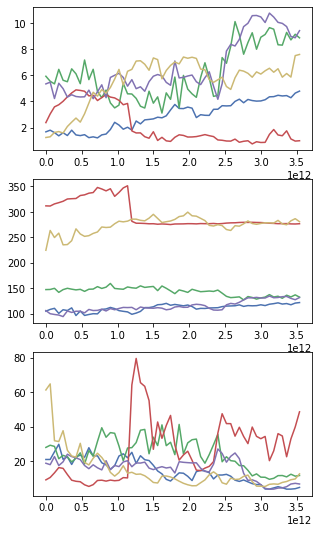

In [9]:
tvar_sort = tvar.sort_values('totalvar', ascending=True).copy()
starttimes = list(tvar_sort.index[0:5])

fig, ax = plt.subplots(3,1, figsize=(5,9))

blocksize = 60
dummyindex = pd.timedelta_range(start = 0, periods=blocksize, freq='1T')
for ii in starttimes:
    plotdat = metdf.loc[ii:ii+pd.Timedelta(blocksize-1, 'T')]
    plotdat.index = dummyindex
    
    ax[0].plot(plotdat.WS)
    ax[1].plot(plotdat.WD)
    ax[2].plot(plotdat.TI)
    

### Mahalanobis distance

True Mahalanobis distance:

$$MD = \sqrt{(x-\mu)^T C^{-1} (x-\mu)}$$

where $x$ is the input data, and $\mu$ is the center of the data determined as the mean along each coodinate variable. In reality, there are a finite number of observations of $x$ and the mean and covariance matrix must be estimated,

$$MD = \sqrt{(x-\hat{\mu})^T \hat{C}^{-1} (x-\hat{\mu})}$$

In [10]:
outlier_error = np.zeros(10000)
noutliers = outlier_error.copy()
t = outlier_error.copy()
tc = outlier_error.copy()
datasize = 1000

for ii in range(len(outlier_error)):
    
    shape_factor = np.random.rand(2)
    scale = np.random.rand(1)*100
    rotation_angle = np.random.rand(1)*2*np.pi
    rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],[np.sin(rotation_angle), -np.cos(rotation_angle)]]).squeeze()

    synthetic_data = TV.standardize_data(np.random.normal(size=(datasize,2), scale=scale))
    synthetic_data = np.matmul(synthetic_data*shape_factor, rotation_matrix)
    clean_data, outliers, outlier_index = TV.find_outliers(synthetic_data, searchtype='mahal')

    t[ii] = TV.covdet(synthetic_data)
    tc[ii] = TV.covdet(clean_data)
    
    noutliers[ii] = len(outlier_index)
    outlier_error[ii] = (t[ii]-tc[ii])/t[ii]

/Users/nhamilto/Documents/Wake_Dynamics/Lillgrund/coderepo/TVAR/tvar_repo/total_var_functions.py:81: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.dot(np.dot((data - center), VI), (data - center).T)))


In [11]:
dfout = pd.DataFrame(data=np.vstack([noutliers, outlier_error]).T, columns=['n_outliers', 'error'])

outlier_stats = dfout.groupby('n_outliers').describe()

outlier_stats.columns = ['_'.join(col).strip() for col in outlier_stats.columns.values]

In [12]:
outlier_stats

,error_count,error_mean,error_std,error_min,error_25%,error_50%,error_75%,error_max
n_outliers,,,,,,,,
2.0,1.0,0.015144,NaN,0.015144,0.015144,0.015144,0.015144,0.015144
3.0,14.0,0.027770,0.003846,0.022261,0.025059,0.028105,0.028890,0.035761
4.0,45.0,0.035562,0.003108,0.030346,0.033848,0.035037,0.036561,0.043545
5.0,139.0,0.044828,0.003945,0.037680,0.041978,0.044176,0.047472,0.055285
6.0,307.0,0.054331,0.005123,0.044815,0.050494,0.053677,0.057261,0.071313
7.0,554.0,0.063637,0.005326,0.053365,0.059814,0.062896,0.066509,0.083097
8.0,881.0,0.071738,0.005602,0.059909,0.067566,0.070757,0.075113,0.091071
9.0,1124.0,0.080463,0.005923,0.066803,0.076054,0.080035,0.083910,0.112419
10.0,1397.0,0.089673,0.006305,0.074934,0.085205,0.088891,0.093257,0.118625


### Scatter plot of a single sample of synthetic data

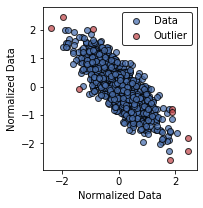

In [13]:
datasize=1000

shape_factor = [1,1/3]# np.random.rand(2)
# scale = np.random.rand(1)*40
rotation_angle = [40]#np.random.rand(1)*2*np.pi
rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],[np.sin(rotation_angle), -np.cos(rotation_angle)]]).squeeze()

synthetic_data = TV.standardize_data(np.random.normal(size=(datasize,2)))
synthetic_data = np.matmul(synthetic_data*shape_factor, rotation_matrix)
clean_data, outliers, outlier_index = TV.find_outliers(synthetic_data, searchtype='mahal')

fig,ax = plt.subplots(figsize=(5,3))
scat = ax.scatter(clean_data[:,0], clean_data[:,1], facecolor='C0', edgecolor='k', alpha=0.75)
outs = ax.scatter(outliers[:,0], outliers[:,1], facecolor='C2', edgecolor='k', alpha=0.75)
ax.set_aspect('equal', 'box')
ax.set_aspect('equal')
ax.set_xlabel('Normalized Data')
ax.set_ylabel('Normalized Data')
ax.legend([scat, outs], ['Data', 'Outlier'], frameon=True, edgecolor='k')#, loc=3)
fig.savefig(os.path.join('figs/data_w_outliers.pdf'))

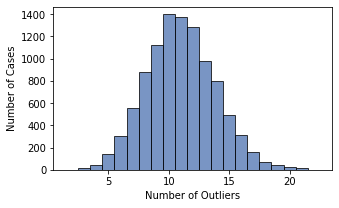

In [14]:
fig, ax = plt.subplots(figsize=(5,3))
ax.bar( outlier_stats.index, outlier_stats.error_count, facecolor='C0', edgecolor='k', alpha=0.75, width=1, linewidth=1)
ax.set_xlabel('Number of Outliers')
ax.set_ylabel('Number of Cases')
fig.savefig(os.path.join('figs/outliers_by_dummy_case.pdf'))

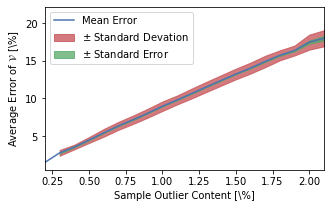

In [15]:
fig, ax = plt.subplots(figsize=(5,3))
xdata = outlier_stats.index/datasize*100

ax.plot(xdata, 100*outlier_stats.error_mean)

upper_error = 100*(outlier_stats.error_mean + outlier_stats.error_std)
lower_error = 100*(outlier_stats.error_mean - outlier_stats.error_std)
ax.fill_between(xdata, upper_error, lower_error, color='C2', alpha=0.75)

upper_error = 100*(outlier_stats.error_mean + outlier_stats.error_std/np.sqrt(outlier_stats.error_count))
lower_error = 100*(outlier_stats.error_mean - outlier_stats.error_std/np.sqrt(outlier_stats.error_count))
ax.fill_between(xdata, upper_error, lower_error, color='C1', alpha=0.75)

ax.set_xlabel('Sample Outlier Content [\%]')
ax.set_ylabel(r'Average Error of $\mathcal{V}$ [\%]')
ax.set_xlim([200/datasize,2100/datasize])

ax.legend(['Mean Error', r'$\pm$ Standard Devation', r'$\pm$ Standard Error'])
fig.savefig(os.path.join('figs/outliers_average_error.pdf'))

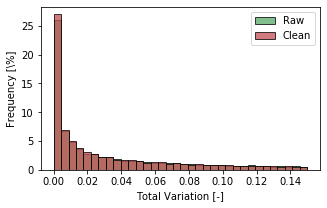

In [16]:
fig,ax = plt.subplots(figsize=(5,3))
bins = np.linspace(0,0.15,35)

ax.hist(t, bins=bins, facecolor='C1', alpha=0.75, edgecolor='k', weights=np.ones(len(t))/len(t)*100)
ax.hist(tc, bins=bins, facecolor='C2', alpha=0.75, edgecolor='k', weights=np.ones(len(t))/len(t)*100)
ax.legend(['Raw', 'Clean'])

ax.set_xlabel(r'Total Variation [-]')
ax.set_ylabel(r'Frequency [\%]')

fig.savefig(os.path.join('figs/tvar_dummy_data.pdf'))